In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.ticker as mtick
import json
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor

def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=1.9)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#00A896", # Persian green
        "#D41876", # Telemagenta
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
make_aesthetic()

# Date Differences for Study 1 and Study 2

In [3]:
def days_difference(start_date, end_date, date_format='%Y-%m-%d'):
    """
    Calculate the difference in days between two dates.
    """
    d1 = datetime.strptime(start_date, date_format)
    d2 = datetime.strptime(end_date, date_format)
    
    return abs((d2 - d1).days)

n_months_dict = {}
n_months_dict['Study1'] = days_difference("2023-03-18", "2023-10-02")/30
n_months_dict['Study2'] = days_difference("2023-03-18", "2023-10-06")/30

# Desc Stats

In [4]:
final_mod = pd.read_csv("processed/s2_mar23_oct23_ideoY_final_mod.csv", dtype={'main':'object', 'followers_id':'object'})

In [5]:
print("Final model followers", final_mod['followers_id'].nunique())
print("Final model spreaders", final_mod['main'].nunique())
print("Final model edges", len(final_mod))

Final model followers 898701
Final model spreaders 5334
Final model edges 3376785


In [6]:
final_mod['change_spreader_tweet_count2'].describe()

count    3.376785e+06
mean     8.037095e+03
std      1.311054e+04
min      0.000000e+00
25%      6.220000e+02
50%      3.376000e+03
75%      9.307000e+03
max      2.134950e+05
Name: change_spreader_tweet_count2, dtype: float64

## Make big table

In [8]:
# Import necessary libraries for statistical analysis
import pandas as pd
import numpy as np


    
# Deduplicate data based on 'followers_id' for follower metrics
follower_dedup = final_mod.drop_duplicates(subset='followers_id')

# Deduplicate data based on 'main' for spreader metrics
spreader_dedup = final_mod.drop_duplicates(subset='main')

# As said in paper in some cases API returned change tweet count as negative so changed to zero then
spreader_dedup['change_spreader_tweet_count'] = spreader_dedup['change_spreader_tweet_count'].apply(lambda x: max(x, 0))



# List of columns for follower metrics and spreader metrics
follower_metrics = ['follower_tweet_count', 'follower_follower_count', 'follower_following_count', "n_spreader_following"]
spreader_metrics = ['spreader_tweet_count', 'spreader_follower_count', 'spreader_following_count', 'change_spreader_tweet_count']

# Initialize an empty DataFrame to store the results
summary_table = pd.DataFrame(columns=['Metric', 'Mean', 'SD', '25%', '50%', '75%'])

# Calculate summary statistics for follower metrics
for metric in follower_metrics:
    summary = follower_dedup[metric].describe(percentiles=[.25, .5, .75])
    summary_table = summary_table.append({'Metric': f'{metric}',
                                          'Mean': summary['mean'],
                                          'SD': summary['std'],
                                          '25%': summary['25%'],
                                          '50%': summary['50%'],
                                          '75%': summary['75%']}, ignore_index=True)

# Calculate summary statistics for spreader metrics
for metric in spreader_metrics:
    summary = spreader_dedup[metric].describe(percentiles=[.25, .5, .75])
    summary_table = summary_table.append({'Metric': f'{metric}',
                                          'Mean': summary['mean'],
                                          'SD': summary['std'],
                                          '25%': summary['25%'],
                                          '50%': summary['50%'],
                                          '75%': summary['75%']}, ignore_index=True)

# Calculate summary statistics for 'theta' (ideology)
summary_ideology = final_mod['theta'].describe(percentiles=[.25, .5, .75])
summary_table = summary_table.append({'Metric': 'ideology (positive is conservative)',
                                      'Mean': np.round(summary_ideology['mean'],2),
                                      'SD': np.round(summary_ideology['std'],2),
                                      '25%': np.round(summary_ideology['25%'],2),
                                      '50%': np.round(summary_ideology['50%'],2),
                                      '75%': np.round(summary_ideology['75%'],2)}, ignore_index=True)

# Calculate 'is_liberal' based on 'theta'
final_mod['is_liberal'] = final_mod['theta'].apply(lambda x: 1 if x < 0 else 0)

# Calculate summary statistics for 'recip' and 'is_liberal' without percentiles
summary_recip = final_mod['recip'].agg(['mean', 'std'])
summary_is_liberal = final_mod['is_liberal'].agg(['mean', 'std'])

# Add 'recip' and 'is_liberal' to the summary table without percentiles
summary_table = summary_table.append({'Metric': 'recip',
                                      'Mean': summary_recip['mean'],
                                      'SD': summary_recip['std'],
                                      '25%': ".",
                                      '50%': ".",
                                      '75%': "."}, ignore_index=True)

summary_table = summary_table.append({'Metric': 'is_liberal',
                                      'Mean': np.round(summary_is_liberal['mean'],2),
                                      'SD': np.round(summary_is_liberal['std'],2),
                                      '25%': ".",
                                      '50%': ".",
                                      '75%': "."}, ignore_index=True)

summary_table['Metric'] = summary_table['Metric'].apply(lambda x: x.replace("_", " ").title())


def format_value(metric, value):
    try:
        if metric == "Is Liberal" or metric == "Recip" or metric=="Ideology (Positive Is Conservative)":
            return str(np.round(value, 2))
        else:
            return str(int((np.round(value))))
    except:
        return value
    

for column in ['Mean', 'SD', '25%', '50%', '75%']:
    summary_table[column] = summary_table.apply(lambda row: format_value(row['Metric'], row[column]), axis=1)


print(summary_table.to_latex(
                                   index=False,
                                         caption=f"Descriptive Statistics of Followers and Spreaders in Study 1. There are {final_mod['followers_id'].nunique()} followers, {final_mod['main'].nunique()} spreaders, {len(final_mod)} edges. Recip is a binary variable denoting if a tie is reciprocated. Is Liberal is an indicator variable denoting if the follower's ideology is calculcated as liberal. The change in spreader tweet count refers to the number of tweets from T1 to T2. In some cases, the API returned less total tweets for the spreader in T2 than T1. In these cases, we changed Change Spreader Tweet Count to zero.", 
                                         label="s1_desc_stats"))








<ipython-input-8-fbb5c73ffd22>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spreader_dedup['change_spreader_tweet_count'] = spreader_dedup['change_spreader_tweet_count'].apply(lambda x: max(x, 0))


\begin{table}
\centering
\caption{Descriptive Statistics of Followers and Spreaders in Study 1. There are 898701 followers, 5334 spreaders, 3376785 edges. Recip is a binary variable denoting if a tie is reciprocated. Is Liberal is an indicator variable denoting if the follower's ideology is calculcated as liberal. The change in spreader tweet count refers to the number of tweets from T1 to T2. In some cases, the API returned less total tweets for the spreader in T2 than T1. In these cases, we changed Change Spreader Tweet Count to zero.}
\label{s1_desc_stats}
\begin{tabular}{llllll}
\toprule
                             Metric &  Mean &     SD &  25\% &   50\% &   75\% \\
\midrule
               Follower Tweet Count & 18116 &  51193 &  566 &  3673 & 14984 \\
            Follower Follower Count &  4311 & 208369 &  130 &   461 &  1510 \\
           Follower Following Count &  2896 &  13362 &  628 &  1442 &  3107 \\
               N Spreader Following &     4 &     13 &    1 &     1 &    

## Get 95% CI using Wilson method 

In [11]:
import statsmodels.stats.proportion as smp



def wilson_score_interval(vector, n_months, confidence_level=0.95, round_param=3):
    """
    Calculate the Wilson Score Interval for a given vector of 0s and 1s.
    """
    count_success = np.sum(vector)
    n = len(vector)
    
    if n == 0:
        return "Vector is empty"
    if not (0 < confidence_level < 1):
        return "Confidence level should be between 0 and 1"
    
    lower, upper = smp.proportion_confint(count_success, n, alpha=1-confidence_level, method='wilson')
    
    est = np.round(np.mean(vector) * 100, round_param)
    
    monthly_rate = np.mean(vector) / n_months
    monthly_lower = lower / n_months
    monthly_upper = upper / n_months
    
    print(f"The rate was {est}\% (95\% CI = [{np.round(lower * 100, round_param)}\%, {np.round(upper * 100, round_param)}\%])")
    print(f"The monthly rate was {np.round(monthly_rate * 100, round_param)}\% (95\% CI = [{np.round(monthly_lower * 100, round_param)}\%, {np.round(monthly_upper * 100, round_param)}\%])")
    
    return est, lower, upper


est, lower, upper = wilson_score_interval(vector=final_mod['unfollowed'], 
                                          round_param=3, 
                                          n_months=n_months_dict['Study1']
                                        )

The rate was 1.273\% (95\% CI = [1.262\%, 1.285\%])
The monthly rate was 0.193\% (95\% CI = [0.191\%, 0.195\%])


## Segment Data

In [12]:
data = final_mod.copy()
data_spreader = data.drop_duplicates(subset='main')
data_follower = data.drop_duplicates(subset='followers_id')

## Ideology

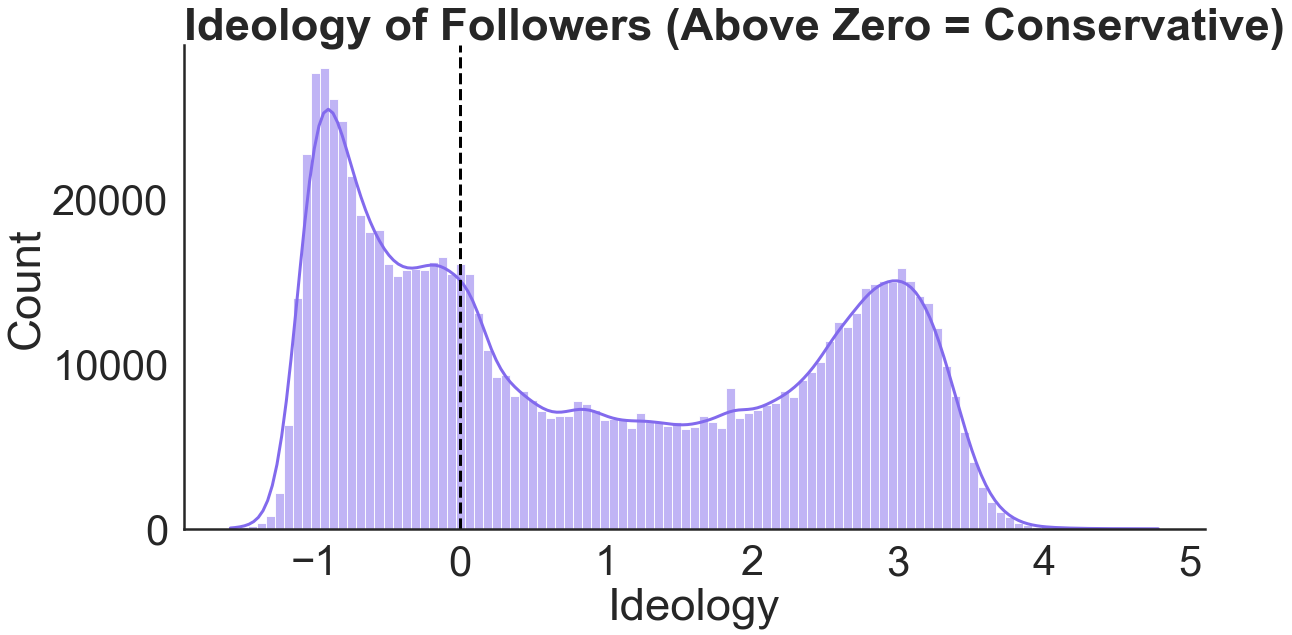

In [13]:
plt.figure(figsize=(18,10))
plt.rcParams['axes.grid'] = False

sns.histplot(data_follower['theta'], kde=True, color='#826AED')
plt.title("Ideology of Followers (Above Zero = Conservative)")
plt.xlabel("Ideology")
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=3)
sns.despine()
plt.tight_layout()
plt.savefig("ideo.png", dpi=400)
plt.show()

## Recip

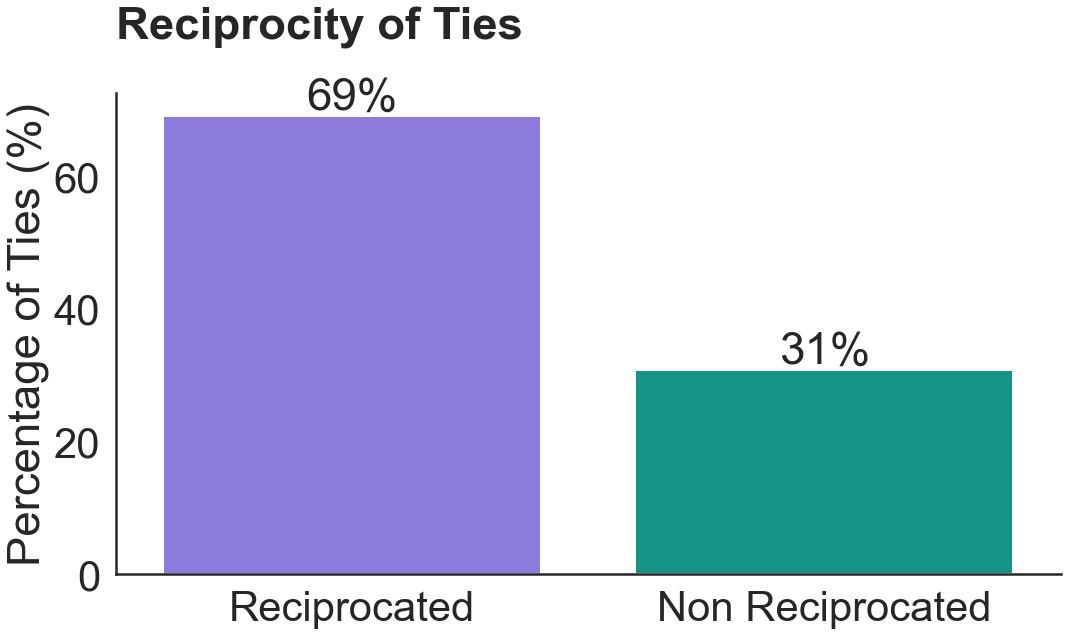

In [14]:
recip_counts = data['recip'].value_counts(normalize=True) * 100
make_aesthetic()
labels = ["Non Reciprocated" if i == 0 else "Reciprocated" for i in recip_counts.index]
plt.rcParams['axes.grid'] = False

plt.figure(figsize=(16,10))
ax = sns.barplot(x=labels, y=recip_counts.values)
plt.title("Reciprocity of Ties\n")
plt.ylabel("Percentage of Ties (%)")

# Adding the percentages above each bar

for index, value in enumerate(recip_counts.values):
    ax.text(index, value + 1, f"{value:.0f}%", ha='center')
plt.tight_layout()
plt.savefig("recip.png", dpi=400)
plt.show()


## Lorenz Stuff

In [15]:
def ginic(x):
    # https://www.ellipsix.net/blog/2012/11/the-gini-coefficient-for-distribution-inequality.html
    # requires all values in x to be zero or positive numbers,
    # otherwise results are undefined
    n = len(x)
    s = x.sum()
    r = np.argsort(np.argsort(-x)) # calculates zero-based ranks
    return 1 - (2.0 * (r*x).sum() + s)/(n*s)

# Computing the sum of reciprocal ties for each spreader
reciprocal_ties = data.groupby('main')['recip'].sum()
in_degree = data.groupby('main').count()['followers_id'].values
tweet_count = data.groupby('main').mean().reset_index()['spreader_tweet_count'].values

print("Gini coefficent of in degree", ginic(in_degree), np.round(ginic(in_degree),2))
print("Gini coefficent of reciprocal ties", ginic(reciprocal_ties), np.round(ginic(reciprocal_ties),2))
print("Gini coefficent of tweet count", ginic(tweet_count),np.round(ginic(tweet_count),2))

# Adding the new column to data_spreader
data_spreader['n_recip'] = data_spreader['main'].map(reciprocal_ties)

# Displaying the first few rows of data_spreader with the new column
data_spreader[['main', 'n_recip']].head()


Gini coefficent of in degree 0.7411853487463717 0.74
Gini coefficent of reciprocal ties 0.7869811010628089 0.79
Gini coefficent of tweet count 0.6620307993214063 0.66


<ipython-input-15-b3f63af221db>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_spreader['n_recip'] = data_spreader['main'].map(reciprocal_ties)


,main,n_recip
0,36861828,24
1,728859242292125696,403
2,1064825975383318528,454
3,395647790,214
4,491783777,315


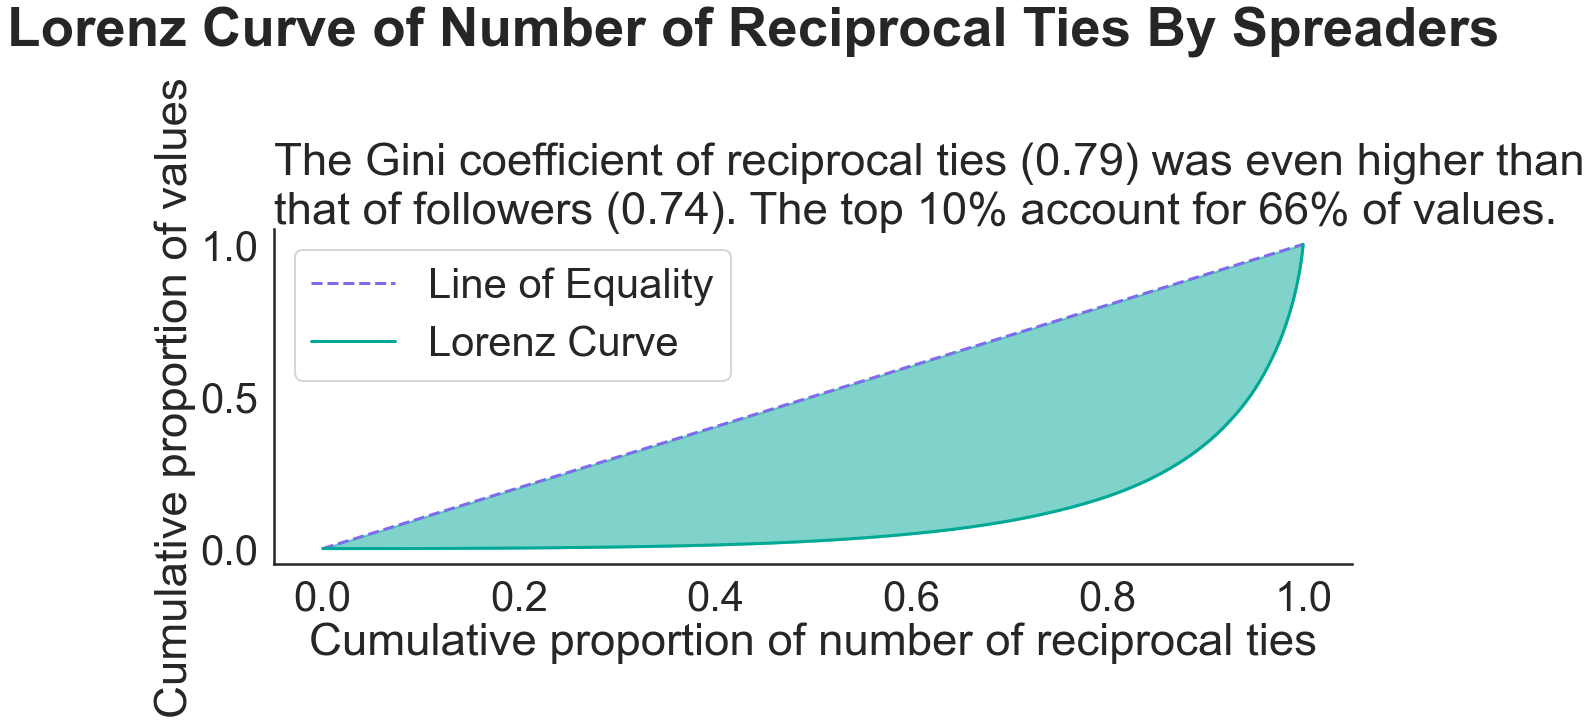

In [16]:

def analyze_top_array(arr):
    """
    Analyzes an array to calculate and return the following:
    - Proportion accounted for by the top 10% of values
    - The top 10% of values
    - The total sum of the array

    Parameters:
    - arr: The array to be analyzed

    Returns:
    - A dict with these metrics
    """

    if len(arr) == 0:
        return {
            'proportion_by_top_10': None,
            'top_10_values': None,
            'total_sum': None
        }

    # Sort the array
    sorted_arr = sorted(arr)
    cutoff_index = int(0.9 * len(sorted_arr))
    top_10_values = sorted_arr[cutoff_index:]
    total_sum = sum(sorted_arr)
    proportion_by_top_10 = sum(top_10_values) / total_sum if total_sum > 0 else 0
    return {
        'top_10_prop': proportion_by_top_10,
        'top_10_values': top_10_values,
        'total_sum': total_sum, 
        "top_10_sum":np.sum(top_10_values)/total_sum
    }


def plot_lorenz_curve(dataframe, column_name, clean_title):
    """
    Plots the Lorenz curve for the specified column in the given DataFrame and calculates the Gini coefficient.
    
    Parameters:
    - dataframe: The DataFrame containing the data.
    - column_name: The column for which the Lorenz curve and Gini coefficient should be computed.
    """
    
    # Sorting data by the specified column and computing the cumulative sum
    sorted_values = np.sort(dataframe[column_name])
    cumulative_values = np.cumsum(sorted_values)
    cumulative_values = cumulative_values.astype(float) / cumulative_values[-1]  # Normalize to [0,1]

    # Calculating the proportion of values accounted for by the top 10%
    cutoff_index = int(0.9 * len(sorted_values))
    sum_top_10_percent = np.sum(sorted_values[cutoff_index:])
    top_10_percent_value = analyze_top_array(sorted_values)['top_10_prop']

    # Creating the Lorenz curve
    x = np.linspace(0, 1, len(cumulative_values) + 1)
    y = np.concatenate([[0], cumulative_values])

    # Calculating the Gini coefficient
    gini_coefficient = 1 - 2 * np.trapz(y, x)

    # Plotting the Lorenz curvez
    plt.figure(figsize=(18, 10))
    plt.plot(x, x, color='#826AED', linestyle='--', label='Line of Equality')
    plt.plot(x, y, color='#00A896', label='Lorenz Curve')
    plt.fill_between(x, x, y, color='#00A896', alpha=0.5)
    plt.suptitle(f"Lorenz Curve of {clean_title} By Spreaders", x=0.5, weight='bold')
    plt.title(f"The Gini coefficient of reciprocal ties ({gini_coefficient:.2f}) was even higher than\nthat of followers ({ginic(in_degree):.2f}). The top 10% account for {top_10_percent_value * 100:.0f}% of values.", fontweight='regular')
    plt.xlabel(f'Cumulative proportion of {clean_title.lower()}')
    plt.ylabel(f'Cumulative proportion of values')
    plt.legend()
    plt.tight_layout()
    plt.savefig("lorenz.png", dpi=400)
    plt.tight_layout()
    plt.show()





plot_lorenz_curve(data_spreader, 'n_recip', "Number of Reciprocal Ties")


## Z Scores of N Recip

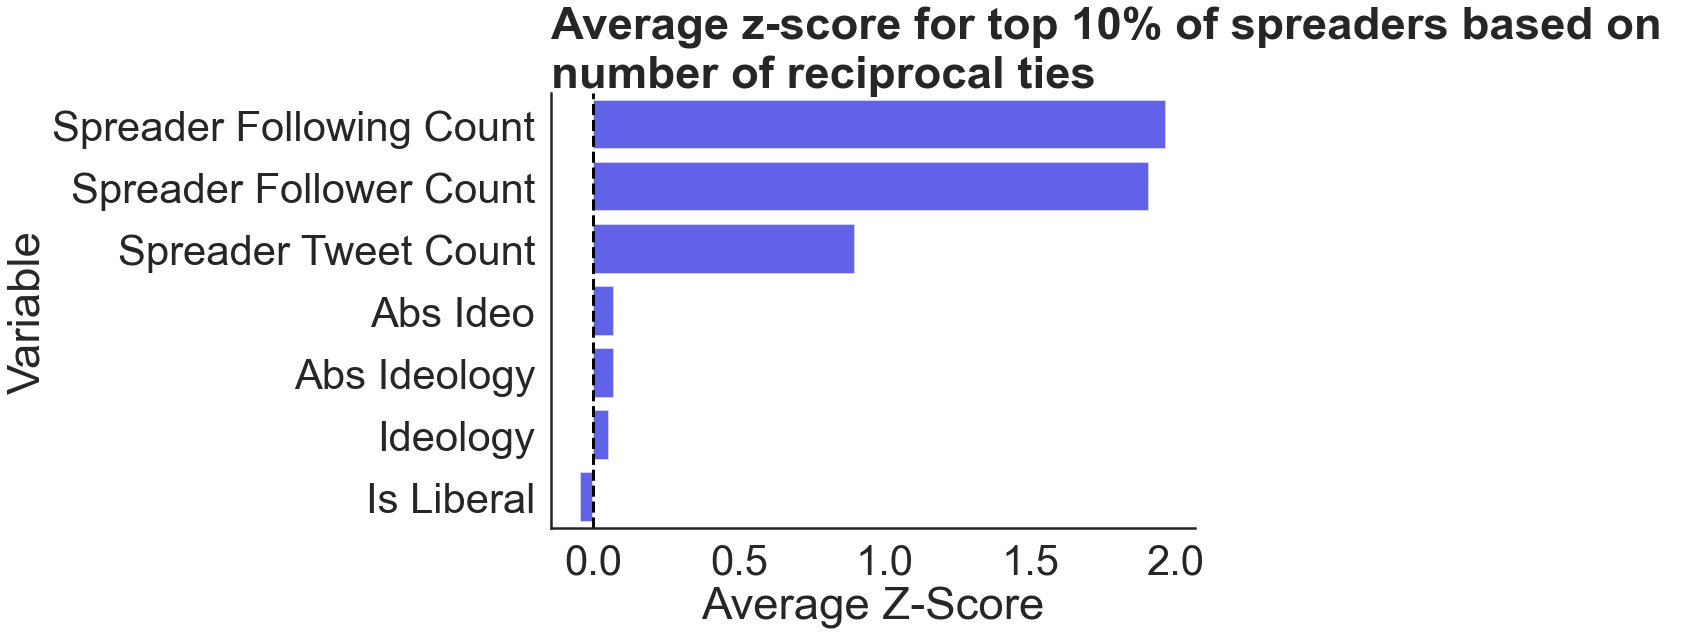

In [17]:
def analyze_top_percentage_modified(data, column_to_analyze, clean_title, percentage):
    """
    Analyzes the top percentage of spreaders based on a specified column.
    
    Parameters:
    - data: The DataFrame containing the data.
    - column_to_analyze: The column based on which the top percentage is determined.
    - percentage: The top percentage to analyze.
    """
    
    # Compute the threshold for the specified percentage
    threshold_value = np.percentile(data[column_to_analyze], 100 - percentage)
    
    # Add a flag to data for spreaders above the threshold
    data['above_threshold'] = data[column_to_analyze] >= threshold_value
    data['ideology'] = data['theta']
    data['abs_ideology'] = np.abs(data['theta'])

    # Compute z-scores for numeric columns
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    for column in numeric_columns:
        data[f'z_{column}'] = (data[column] - data[column].mean()) / data[column].std()
    
    # Filter data for those above the threshold
    top_data = data[data['above_threshold']]
    
    # Compute mean z-scores for this top group, excluding specified columns
    mean_z_scores = top_data[[col for col in data.columns if col.startswith('z_') 
                              and 'Unnamed' not in col 
                              and 'user_id' not in col 
                              and "t2" not in col
                              and "recip" not in col
                              and "ratio" not in col 
                              and "dist" not in col
                              and "popularity" not in col
                              and "unfollowed" not in col
                              and "follower_follower" not in col
                              and "follower_tweet" not in col 
                              and "follower_following" not in col
                              and "n_spreader" not in col
                              and 'theta' not in col
                              and 'change' not in col]].mean().reset_index()
    
    mean_z_scores.columns = ['variable', 'z-score']
    mean_z_scores['variable'] =  mean_z_scores['variable'].apply(lambda x: x.replace("z_", "").replace("_", " ").title())
    mean_z_scores = mean_z_scores.sort_values(by=['z-score'], ascending=False)

    # Plotting
    plt.figure(figsize=(18, 10))
    sns.barplot(y='variable', x='z-score', data=mean_z_scores, color='blue', alpha=0.7)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Average z-score for top {percentage}% of spreaders based on {clean_title.lower()}", x=-0, fontweight='bold')
    plt.ylabel("Variable")
    plt.xlabel("Average Z-Score")
    sns.despine()
    plt.tight_layout()
    plt.savefig("z_score.png", dpi=400)
    plt.tight_layout()
    plt.show()

analyze_top_percentage_modified(data_spreader.copy(), 'n_recip',"\nNumber of Reciprocal Ties", 10)



## N Spreader Following Histogram

<ipython-input-18-ac8cf6ae9f1d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_follower['Ideology'] = np.where(data_follower['theta'] < 0, 'Liberal', 'Conservative')


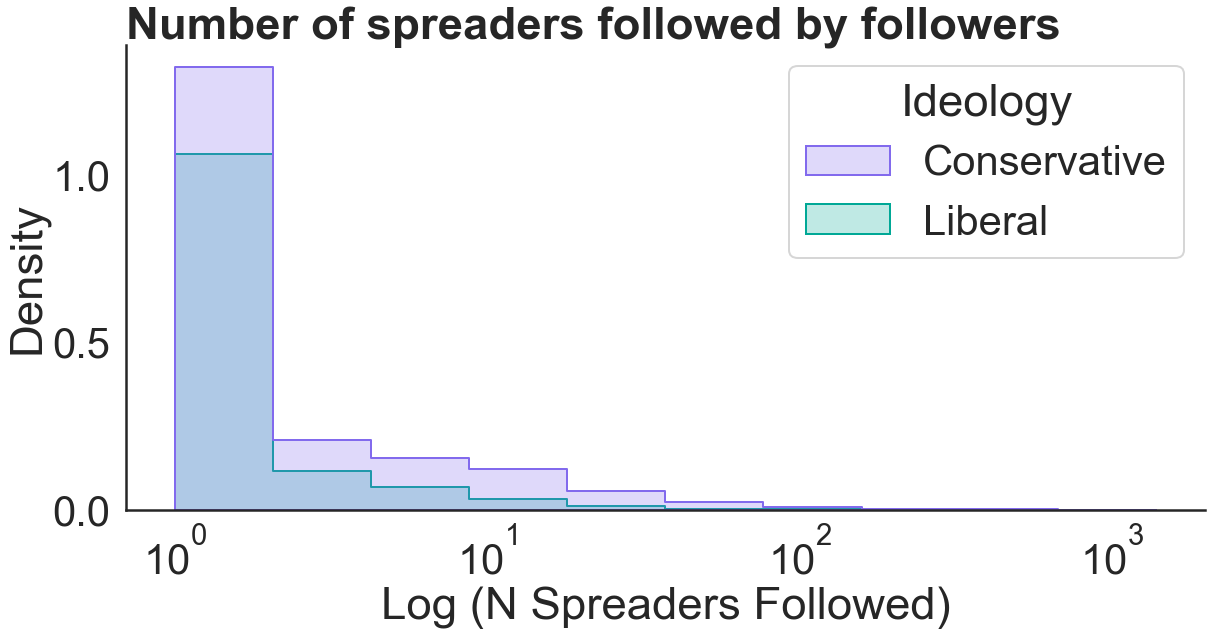

In [18]:
# Plotting histogram with KDE overlay
plt.figure(figsize=(18, 10))
log_values = np.log(data_follower["n_spreader_following"])
data_follower['Ideology'] = np.where(data_follower['theta'] < 0, 'Liberal', 'Conservative')
sns.histplot(x='n_spreader_following', hue='Ideology', log_scale=True, bins=10, data=data_follower,  element='step', stat='density')

# Title and labels
plt.title("Number of spreaders followed by followers")
plt.xlabel("Log (N Spreaders Followed)")
plt.ylabel("Density")
sns.despine()
sns.despine()
plt.tight_layout()
plt.savefig("n_spreader_following.png", dpi=400)
plt.tight_layout()
plt.show()


## N Spreader Following Z

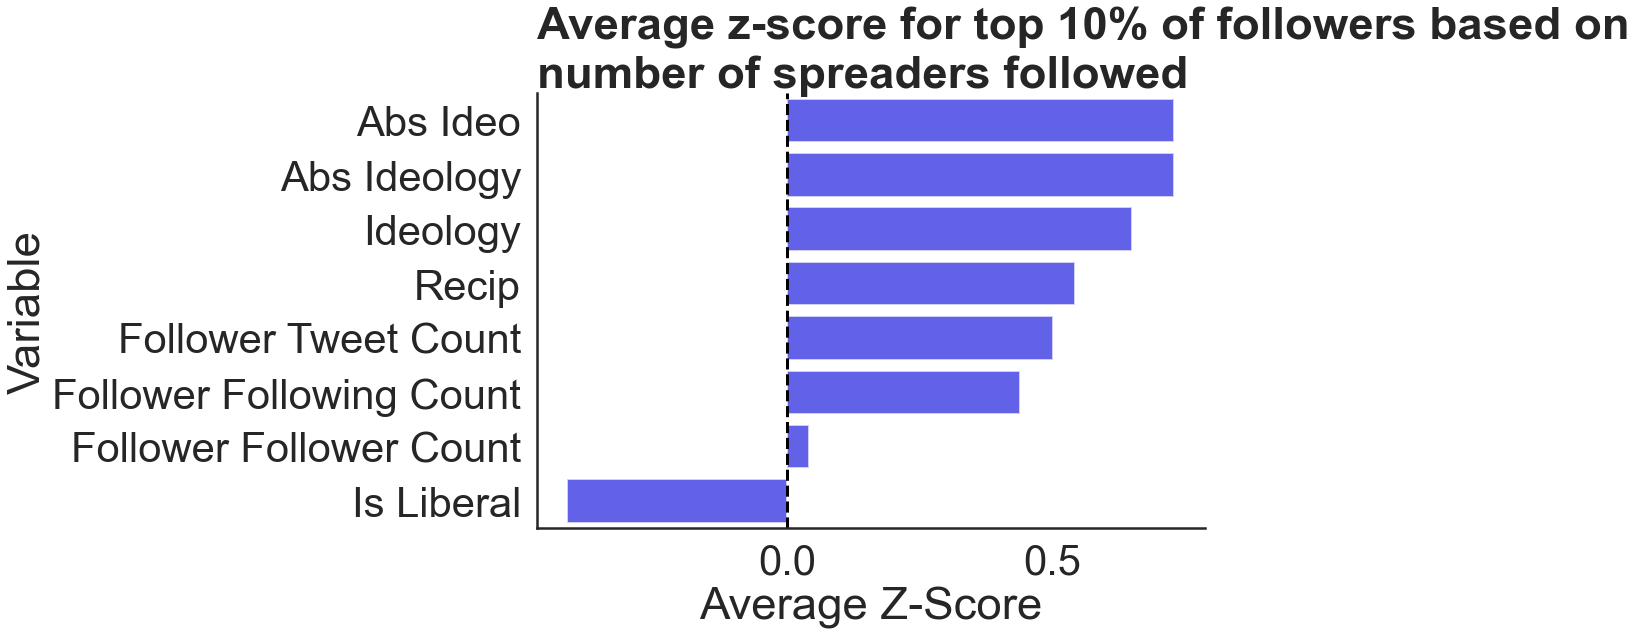

In [19]:
def analyze_top_percentage_modified(data, column_to_analyze, clean_title, percentage):
    """
    Analyzes the top percentage of spreaders based on a specified column.
    
    Parameters:
    - data: The DataFrame containing the data.
    - column_to_analyze: The column based on which the top percentage is determined.
    - percentage: The top percentage to analyze.
    """
    
    # Compute the threshold for the specified percentage
    threshold_value = np.percentile(data[column_to_analyze], 100 - percentage)
    
    # Add a flag to data for spreaders above the threshold
    data['above_threshold'] = data[column_to_analyze] >= threshold_value
    data['ideology'] = data['theta']
    data['abs_ideology'] = np.abs(data['theta'])

    # Compute z-scores for numeric columns
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    for column in numeric_columns:
        data[f'z_{column}'] = (data[column] - data[column].mean()) / data[column].std()
    
    # Filter data for those above the threshold
    top_data = data[data['above_threshold']]
    
    # Compute mean z-scores for this top group, excluding specified columns
    mean_z_scores = top_data[[col for col in data.columns if col.startswith('z_') 
                              and 'Unnamed' not in col 
                              and 'user_id' not in col 
                              and "t2" not in col
                              and "popularity" not in col
                              and "ratio" not in col
                              and "unfollowed" not in col
                              and "spreader_follower" not in col
                              and "spreader_tweet" not in col 
                              and "spreader_following" not in col
                              and "n_spreader" not in col
                              and 'theta' not in col
                              and 'change' not in col]].mean().reset_index()
    
    mean_z_scores.columns = ['variable', 'z-score']
    mean_z_scores['variable'] =  mean_z_scores['variable'].apply(lambda x: x.replace("z_", "").replace("_", " ").title())
    mean_z_scores = mean_z_scores.sort_values(by=['z-score'], ascending=False)

    # Plotting
    plt.figure(figsize=(18, 10))
    sns.barplot(y='variable', x='z-score', data=mean_z_scores, color='blue', alpha=0.7)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Average z-score for top {percentage}% of followers based on {clean_title.lower()}", x=-0, fontweight='bold')
    plt.ylabel("Variable")
    plt.xlabel("Average Z-Score")
    sns.despine()
    plt.tight_layout()
    plt.savefig("z_score_follower.png", dpi=400)
    plt.tight_layout()
    plt.show()




analyze_top_percentage_modified(data_follower.copy(), 'n_spreader_following',"\nNumber of spreaders followed", 10)


# Comparison To Previous Study

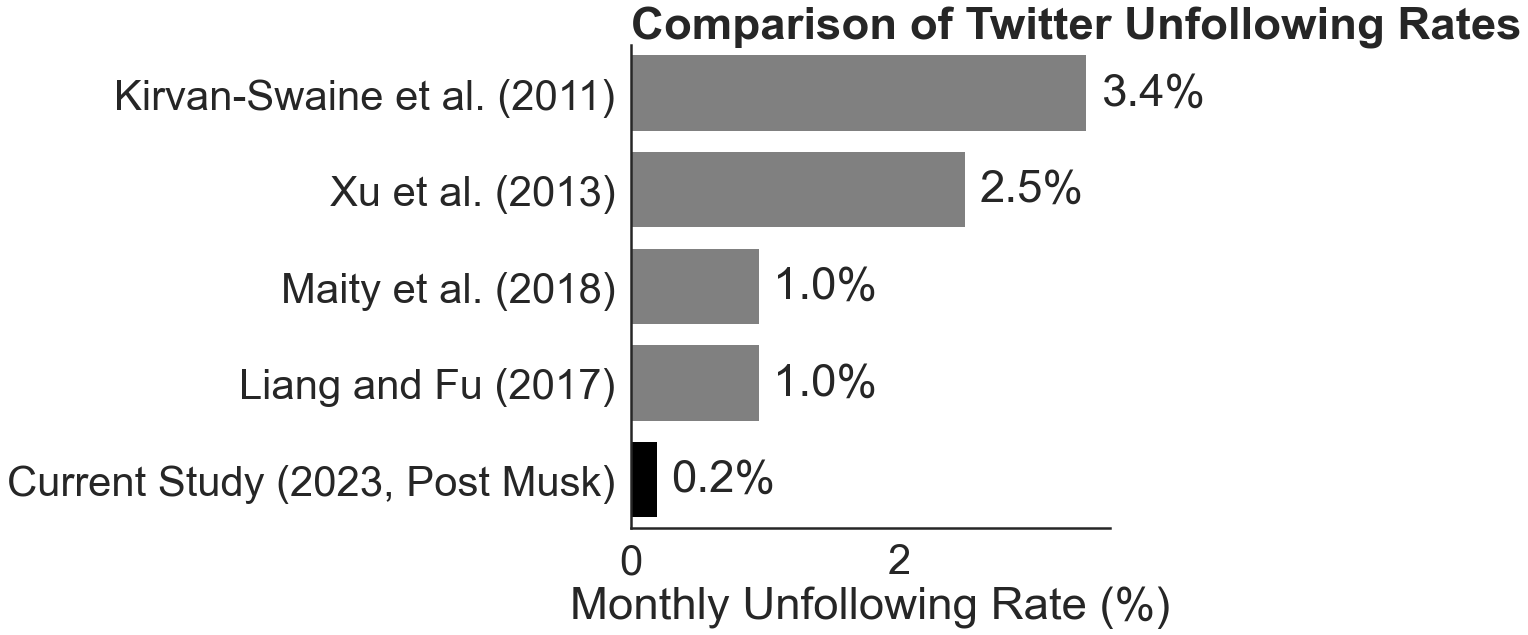

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data and calculations
make_aesthetic()
n_days = 198
n_months = n_days / 30
unfollowing_rate = 100 * data['unfollowed'].mean()
monthly_rate = np.round(unfollowing_rate / n_months, 1)

unfollowing_rates = {
    'study': ["Current Study (2023, Post Musk)", 
              'Kirvan-Swaine et al. (2011)', 
              'Xu et al. (2013)', 
              'Maity et al. (2018)', 
              'Liang and Fu (2017)'],
    'rates': [monthly_rate, 3.4, 2.5, 0.96, 0.96]
}

# Create a DataFrame from the data
df = pd.DataFrame(unfollowing_rates)

# Sort the DataFrame by 'rates'
sorted_df = df.sort_values(by='rates', ascending=False)
plt.rcParams['axes.grid'] = False


# Create the bar plot using Seaborn
plt.figure(figsize=(18, 10))

# Define colors for bars
colors = ['gray' if study != "Current Study (2023, Post Musk)" else 'black' for study in sorted_df['study']]

ax = sns.barplot(data=sorted_df, y='study', x='rates', palette=colors)
plt.xlabel('Monthly Unfollowing Rate (%)')
plt.ylabel("")
plt.title('Comparison of Twitter Unfollowing Rates')
plt.tight_layout()

for i, rate in enumerate(sorted_df['rates']):
    plt.text(rate + 0.1, i, f'{rate:.1f}%', va='center')
sns.despine()
plt.tight_layout()
plt.savefig("unfollow.png", dpi=400)
plt.show()


# By Reciprocity

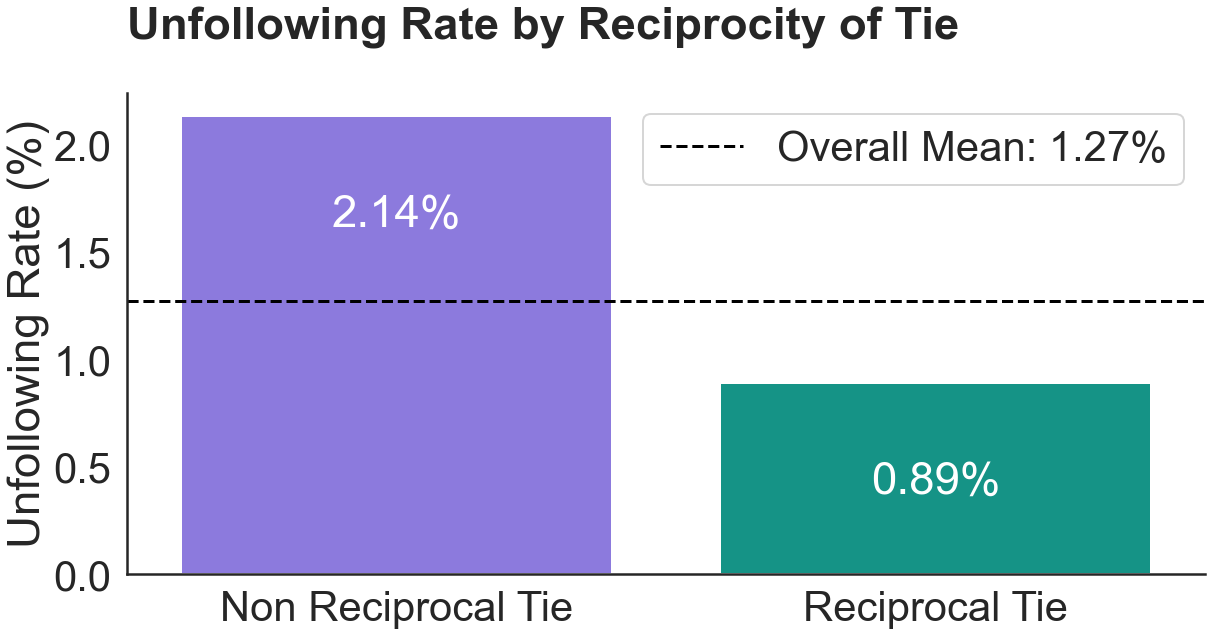

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you've already created the 'rr' DataFrame from your data
rr = data.groupby(by=['recip'])['unfollowed'].mean().reset_index()
plt.figure(figsize=(18,10))

# Create the barplot
ax = sns.barplot(data=rr, x='recip', y=rr['unfollowed']*100)

# Rename the x-labels as described
ax.set_xticklabels(["Non Reciprocal Tie", "Reciprocal Tie"])

# For adding text above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()-0.5), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                color='white',
                textcoords = 'offset points')

plt.title("Unfollowing Rate by Reciprocity of Tie \n")
plt.ylabel('Unfollowing Rate (%)')  # Adjusting the y-label to make it clearer that it's in percentage
plt.xlabel('')  # Adjusting the y-label to make it clearer that it's in percentage
overall_mean = data['unfollowed'].mean() * 100

# Add a horizontal line for the overall mean
plt.axhline(y=overall_mean, color='black', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}%')
plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig("recip_rates.png", dpi=400)
plt.show()


# Study 2

## Read in dataframes

In [22]:
fp1 = pd.read_csv("__MINIMAL_FRIENDS_03.29.2023__22.22.10__START0_END-1_merged_OBS.csv", dtype={'main':'object', 'friends_id':'object'})
fp2 = pd.read_csv("__MINIMAL_FRIENDS_10.06.2023__05.51.02__START0_END-1_merged.csv", dtype={'main':'object', 'friends_id':'object'})
friends2 = pd.read_csv("HydratedObsFriends_ND22_t1_t3_fix___10.04.2023__13.05.27__START0_END-1_merged.csv", dtype={'user_id':'object'})


## Process different rates

In [31]:
def identify_banned_users():
    exited = ['suspended', 'deactivated']
    alter_compliance = jsonl2df("alter_compliance_job.jsonl").query("reason in @ exited")
    ego_compliance = jsonl2df("ego_compliance_job.jsonl").query("reason in @ exited")
    banned_egos = set(ego_compliance['id'].unique())
    banned_alters = set(alter_compliance['id'].unique())
    return banned_egos, banned_alters

def jsonl2df(filename):
    data = []
    with open(filename, 'r') as file:
        for idx, line in enumerate(file, start=1):
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"Error processing line {idx}: {line.strip()}")
    return pd.DataFrame(data)



def process_condition(fp1, fp2, friends, final_mod, query_str, condition_name, banned_mains=None, banned_friends=None):
    if banned_mains is None or banned_friends is None:
        banned_mains, banned_friends = identify_banned_users(fp1, friends)
    
    edges = remove_banned_users(fp1, fp2, banned_mains, banned_friends, query_str)
    edges_augment = process_data(edges, final_mod)
    
    return {condition_name: edges_augment}

def remove_banned_users(fp1, fp2, banned_mains, banned_friends, query_str):
    edges = pd.merge(fp1, fp2, on=['main', 'friends_id'], how='left', indicator="unfollowed")
    edges['unfollowed'] = (edges['unfollowed'] == 'left_only').astype(int)
    edges = edges.query(query_str)
    return edges

def process_data(edges, final_mod):
    id_followers = set(final_mod['followers_id'].unique())
    obs_followers = set(edges['main'].unique())
    
    edges_augment = pd.merge(
        edges, 
        final_mod[['main', 'followers_id', 'recip', 
                   'follower_follower_count', 'follower_following_count',
                   'follower_tweet_count', 'spreader_follower_count',
                   'spreader_following_count', 'spreader_tweet_count', 
                   'theta']],
        left_on=['main', 'friends_id'], 
        right_on=['followers_id', 'main'], 
        how='left', 
        indicator="is_spreader"
    )
    
    edges_augment['is_spreader'] = (edges_augment['is_spreader'] == 'both').astype(int)
    return edges_augment


def print_summary(edges_augment):
    print("Total edges after matching", len(edges_augment))
    print("Number of edges that are spreaders", edges_augment['is_spreader'].sum())
    print("Number of edges that are spreaders dissolved", np.sum(edges_augment['is_spreader'] * edges_augment['unfollowed']))
    print(np.round(edges_augment[edges_augment['is_spreader'] == 1]['unfollowed'].mean()*100,2))
    print(np.round(edges_augment[edges_augment['is_spreader'] == 0]['unfollowed'].mean()*100,2))
    
    
conditions = {
    'unfollowing': "not (friends_id in @banned_friends or main in @banned_mains)", 
    "wrong":"not (friends_id in @banned_mains)"

}

# Initial ban identification (to avoid redundant calculations)
banned_mains, banned_friends = identify_banned_users()
results = {}
for condition_name, query_str in conditions.items():
    results.update(
        process_condition(
            fp1, fp2, friends2, final_mod,
            query_str, condition_name,
            banned_mains, banned_friends
        )
    )

edges_augment = results['unfollowing']

Error processing line 35527: 
Error processing line 48: 


## Simple bar Chart

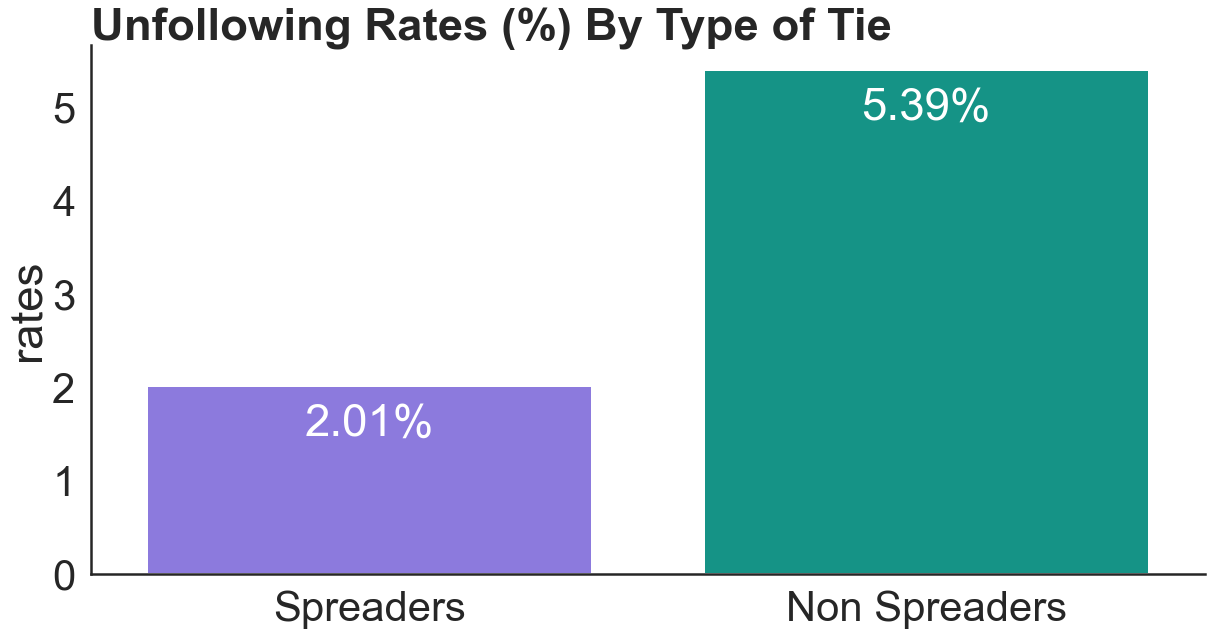

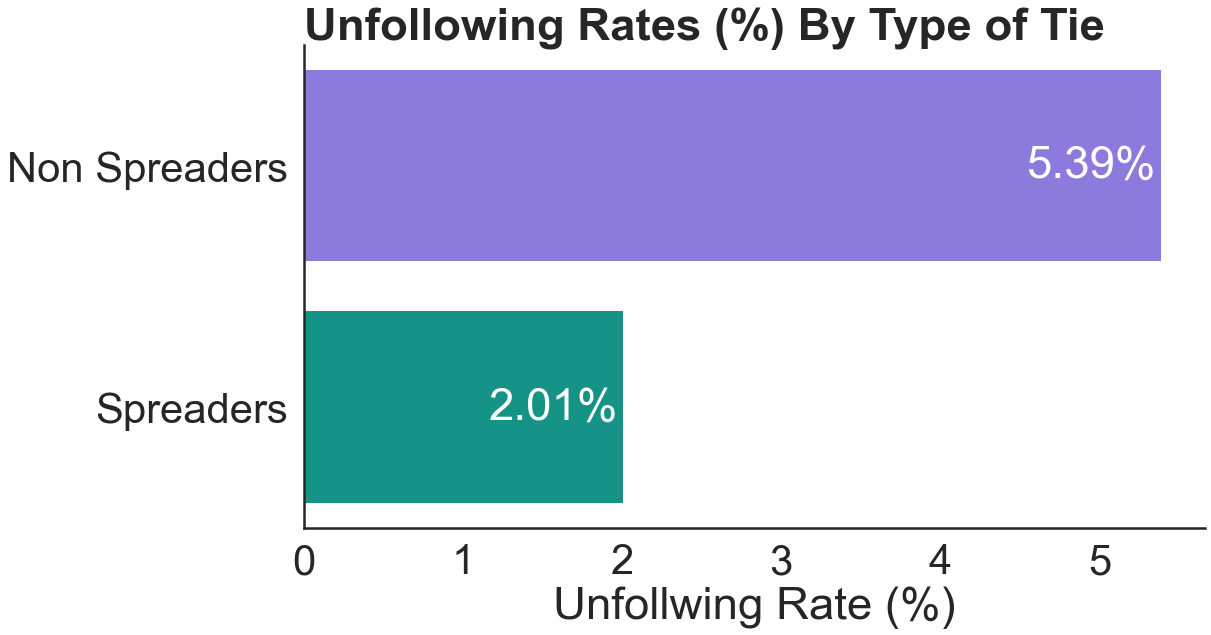

In [55]:
rd = pd.DataFrame({
    "rates": [
        np.round(edges_augment[edges_augment['is_spreader'] == 1]['unfollowed'].mean()*100,2),
        np.round(edges_augment[edges_augment['is_spreader'] == 0]['unfollowed'].mean()*100,2)
    ],
    "group": ["Spreaders", "Non Spreaders"]
})

plt.figure(figsize=(18,10))
ax = sns.barplot(data=rd, x='group', y='rates')

# For adding text above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()-0.5), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                color='white',
                textcoords = 'offset points')
    
    
plt.title("Unfollowing Rates (%) By Type of Tie")
plt.xlabel("Unfollowing Rate (%)")

plt.xlabel("")
sns.despine()
plt.rcParams['axes.grid'] = False
plt.tight_layout()
plt.savefig("unfollow_2__vertical_obs.png", dpi=400)
plt.show()




rd = pd.DataFrame({
    "rates": [
        np.round(edges_augment[edges_augment['is_spreader'] == 0]['unfollowed'].mean()*100,2),
        np.round(edges_augment[edges_augment['is_spreader'] == 1]['unfollowed'].mean()*100,2),

    ],
    "group": ["Non Spreaders", "Spreaders"]
})

plt.figure(figsize=(18,10))
ax = sns.barplot(data=rd, y='group', x='rates')
# For adding text beside each bar
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%', 
                (p.get_width() - 0.5, p.get_y() + p.get_height()/2), 
                ha='center', va='center', 
                xytext=(9, 0), 
                color='white',
                textcoords='offset points')

# plt.title("Unfollowing Rates (%) By Type of Tie")
# plt.xlabel("Unfollowing Rate (%)")

plt.title("Unfollowing Rates (%) By Type of Tie")
plt.xlabel("Unfollwing Rate (%)")
plt.rcParams['axes.grid'] = False

plt.ylabel("")
sns.despine()
plt.tight_layout()
plt.savefig("unfollow_2_obs.png", dpi=400)
plt.show()

## Get CI

In [40]:
print("Spreaders")
est, lower, upper = wilson_score_interval(edges_augment[edges_augment['is_spreader'] == 1]['unfollowed'], round_param=3, n_months=n_months_dict['Study2'])
print("Non spreaders")
est, lower, upper = wilson_score_interval(edges_augment[edges_augment['is_spreader'] == 0]['unfollowed'], round_param=3,n_months=n_months_dict['Study2'])

Spreaders
The rate was 2.006\% (95\% CI = [1.719\%, 2.34\%])
The monthly rate was 0.298\% (95\% CI = [0.255\%, 0.348\%])
Non spreaders
The rate was 5.387\% (95\% CI = [5.368\%, 5.407\%])
The monthly rate was 0.8\% (95\% CI = [0.797\%, 0.803\%])


## Comparison to previous (add obs)

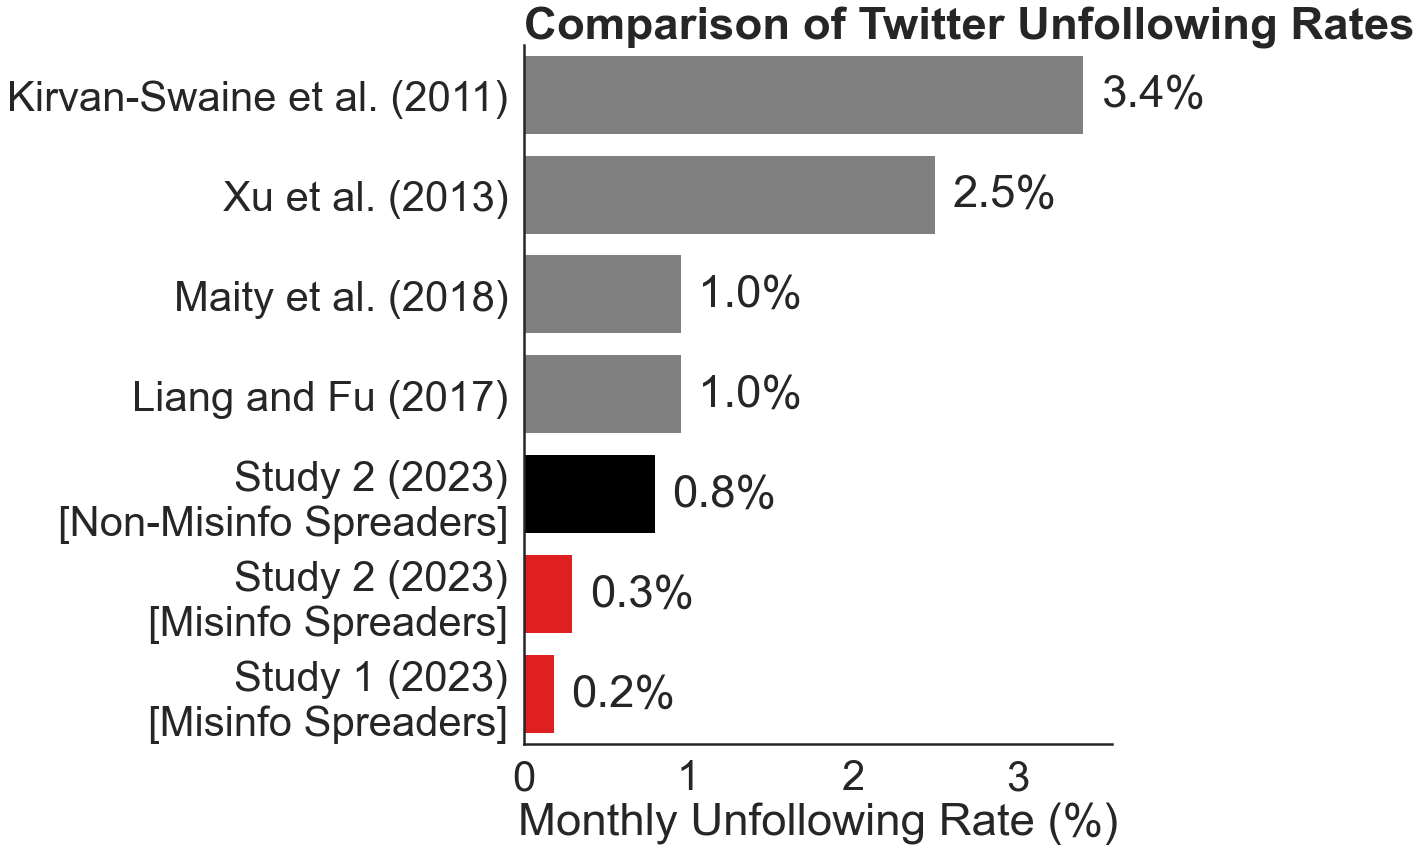

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def pick_color(x):
    if "Study" not in x:
        return 'gray'
    elif "Non-Misinfo Spreaders" in x:
        return "black"
    else:
        return "red"

# Sample data and calculations

# Unfollow rate of initial study 
s1_monthly_rate = np.round((data['unfollowed'].mean() / n_months_dict['Study1'])*100,2)


# Unfollow rate of Study 2
s2_non_misinfo_monthly_unfollowing_rate = np.round((edges_augment[edges_augment['is_spreader'] == 0]['unfollowed'].mean() / n_months_dict['Study2'])*100, 2)
s2_misinfo_monthly_unfollowing_rate = np.round((edges_augment[edges_augment['is_spreader'] == 1]['unfollowed'].mean() / n_months_dict['Study2'])*100, 2)


unfollowing_rates = {
    'study': ["Study 1 (2023)\n[Misinfo Spreaders]", 
              "Study 2 (2023)\n[Non-Misinfo Spreaders]",
            "Study 2 (2023)\n[Misinfo Spreaders]",
              'Kirvan-Swaine et al. (2011)', 
              'Xu et al. (2013)', 
              'Maity et al. (2018)', 
              'Liang and Fu (2017)'],
    'rates': [s1_monthly_rate, s2_non_misinfo_monthly_unfollowing_rate, s2_misinfo_monthly_unfollowing_rate, 3.4, 2.5, 0.96, 0.96]
}

# Create a DataFrame from the data
df = pd.DataFrame(unfollowing_rates)

# Sort the DataFrame by 'rates'
sorted_df = df.sort_values(by='rates', ascending=False)
plt.rcParams['axes.grid'] = False

# Create the bar plot using Seaborn
plt.figure(figsize=(18, 13))

# Define colors for bars
colors = [pick_color(x) for x in sorted_df['study']]

ax = sns.barplot(data=sorted_df, y='study', x='rates', palette=colors)
plt.xlabel('Monthly Unfollowing Rate (%)')
plt.ylabel("")
plt.title("Comparison of Twitter Unfollowing Rates")
plt.tight_layout()

for i, rate in enumerate(sorted_df['rates']):
    plt.text(rate + 0.1, i, f'{rate:.1f}%', va='center')
sns.despine()
plt.tight_layout()
plt.savefig("unfollow_obs.png", dpi=400)
plt.show()


## Hypergeometric

In [51]:
original_ties = len(edges_augment)
original_ties_spreader = len(edges_augment.query("is_spreader==1"))
original_ties_non_spreader = len(edges_augment.query("is_spreader==0"))
original_ties_spreader_percent = np.round((original_ties_spreader / (original_ties_spreader + original_ties_non_spreader))*100,2)


severed_ties =  len(edges_augment.query("unfollowed==1"))
severed_spreader_ties =  len(edges_augment.query("unfollowed==1 & is_spreader==1"))
severed_non_spreader_ties =  len(edges_augment.query("unfollowed==1 & is_spreader==0"))
severed_ties_spreader_percent = np.round((severed_spreader_ties / (severed_spreader_ties + severed_non_spreader_ties))*100,2)


# Original ties details
print(f"There were {original_ties} original ties in total.")
print(f"Out of these, {original_ties_spreader} were with spreaders which is {original_ties_spreader_percent}% of the ties with non-spreaders.")

# Severed ties details
print(f"\nOut of all ties, {severed_ties} were severed.")
print(f"Of the severed ties, {severed_spreader_ties} were with spreaders.")
print(f"This means that {severed_ties_spreader_percent}% of the severed ties with non-spreaders were with spreaders.")



There were 5144149 original ties in total.
Out of these, 7875 were with spreaders which is 0.15% of the ties with non-spreaders.

Out of all ties, 276872 were severed.
Of the severed ties, 158 were with spreaders.
This means that 0.06% of the severed ties with non-spreaders were with spreaders.


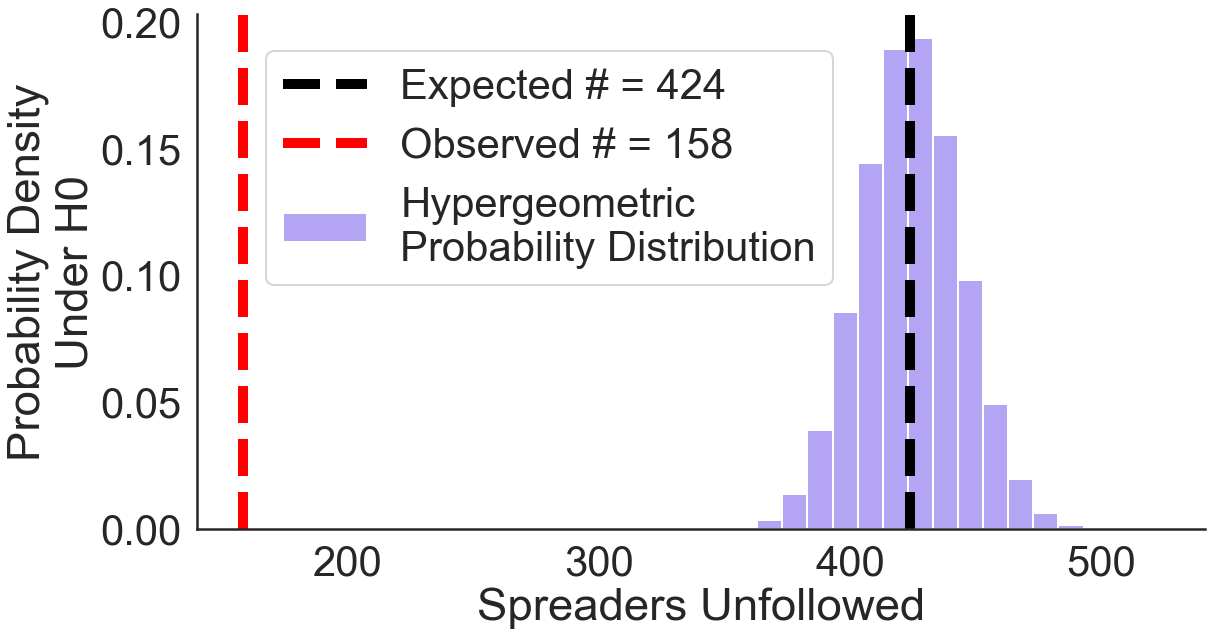

In [64]:
from scipy.stats import hypergeom

# Given parameters
N = original_ties
K = original_ties_spreader
n = severed_ties
k = severed_spreader_ties

k_values = np.arange(0, n+1)  # All possible outcomes of 'spreaders unfollowed'


p_value = hypergeom.cdf(k, N, K, n)


# Using scipy's hypergeometric distribution function
probabilities_scipy = hypergeom.pmf(k_values, N, K, n)

# Calculate the mean of the hypergeometric distribution
mean_k = (n * K) / N

# Define the range around the mean
lower_bound_mean = int(mean_k - 100)
upper_bound_mean = int(mean_k + 100)

# Filter k values and probabilities based on the new range
filtered_k_values_mean = k_values[(k_values >= lower_bound_mean) & (k_values <= upper_bound_mean)]
filtered_probabilities_mean = probabilities_scipy[(k_values >= lower_bound_mean) & (k_values <= upper_bound_mean)]



plt.figure(figsize=(18, 10))
sns.histplot(x=filtered_k_values_mean, weights=filtered_probabilities_mean, bins=int(len(filtered_k_values_mean)/10), color="#826AED",  alpha=0.6,  label="Hypergeometric\nProbability Distribution", kde=False)
# Check if observed k is within the filtered range and plot accordingly


plt.axvline(mean_k, color="black", linestyle="--", linewidth=10, label=f"Expected # = {mean_k:.0f}")
plt.axvline(k, color="red", linestyle="--", label=f"Observed # = {k}", linewidth=10)

# plt.title("Observed number of spreaders unfollowed\nvs null distribution if unfollowing was random\n", fontweight='bold')
plt.xlabel("Spreaders Unfollowed")
plt.ylabel("Probability Density\nUnder H0")
plt.legend(loc="center", bbox_to_anchor=(0.35, 0.7))

sns.despine()
plt.tight_layout()
plt.savefig("unfollow_obs_p.png", dpi=400)
plt.show()
